In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


----------------

***Installing Important Libraries***

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
!pip install -q seqeval

     |████████████████████████████████| 4.7 MB 32.8 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 596 kB 75.2 MB/s 
     |████████████████████████████████| 6.6 MB 58.8 MB/s 
     |████████████████████████████████| 365 kB 24.7 MB/s 
     |████████████████████████████████| 115 kB 51.9 MB/s 
     |████████████████████████████████| 212 kB 58.9 MB/s 
     |████████████████████████████████| 141 kB 55.2 MB/s 
     |████████████████████████████████| 127 kB 70.7 MB/s 
     |████████████████████████████████| 69 kB 7.1 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 


--------------------

***Import Libraries***

In [102]:
import numpy as np
import pandas as pd
import random
import pprint, time
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim


from transformers import BertTokenizerFast , BertTokenizer, AutoTokenizer
from transformers import BertModel

---------------------

***Load and Prepare Data***

In [ ]:
train_file = open('/content/gdrive/MyDrive/NLP - HW6/Train.txt','r')

train = [t.replace('\n','').split() for t in train_file.readlines() ]
tags  = list(set([ tup[1] for tup in train if tup!=[]]))

train_untagged = []
train_tags = []
new_train = []
new = []
new_text = []
new_tags = []
for t in train:
  if t == []:
    new_train.append(new)
    train_untagged.append(new_text)
    train_tags.append(new_tags)
    new = []
    new_text = []
    new_tags = []
  else:
    new.append((t[0],t[1]))
    new_text.append(t[0])
    new_tags.append(t[1])

Xtrain = new_train

In [ ]:
X_train, X_val = train_test_split(list(range(len(Xtrain))),test_size=0.01, random_state=0)

In [ ]:
test_file = open('/content/gdrive/MyDrive/NLP - HW6/Test.txt','r')
test = [t.replace('\n','').split() for t in test_file.readlines() ]

test_untagged = []
test_tags = []
new_test = []
new = []
new_text = []
new_tags = []
for t in test:
  if t == []:
    new_test.append(new)
    test_untagged.append(new_text)
    test_tags.append(new_tags)
    new = []
    new_text = []
    new_tags = []
  else:
    new.append((t[0],t[1]))
    new_text.append(t[0])
    new_tags.append(t[1])

Xtest = new_test

In [ ]:
print(f'Number of Sentences in Train courpes = {len(Xtrain)}')
print(f'Number of Sentences in Test courpes = {len(Xtest)}')

Number of Sentences in Train courpes = 8721
Number of Sentences in Test courpes = 9279


In [ ]:
tags

['V',
 'PRO',
 'DET',
 'MS',
 'N',
 'OH',
 'OHH',
 'PS',
 'ADJ',
 'MORP',
 'IF',
 'P',
 'INT',
 'DEFAULT',
 'AR',
 'NP',
 'MQUA',
 'QUA',
 'DELM',
 'ADV',
 'CON',
 'PP',
 'SPEC']

In [ ]:
tag2id = {tag:idx for idx, tag in enumerate(tags)}
id2tag = {idx:tag for idx, tag in enumerate(tags)}

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

data = DatasetDict({'train':Dataset.from_dict({'pos':[[tag2id[x] for x in t] for t in [train_tags[i] for i in X_train]],'tokens':[train_untagged[i] for i in X_train]}),
                    'val':Dataset.from_dict({'pos':[[tag2id[x] for x in t] for t in [train_tags[i] for i in X_val]],'tokens':[train_untagged[i] for i in X_val]}),
     'test':Dataset.from_dict({'pos':[[tag2id[x] for x in t] for t in test_tags],'tokens':test_untagged})
     })

----------------------

*Prepare Data for feeding to BERT model*

In [ ]:
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

example of tokenizing a train text:

In [ ]:
inputs = tokenizer(data['train'][0]['tokens'], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'در',
 'سي',
 '##ستم',
 '##ها',
 '##ي',
 'حرارت',
 '##ي',
 'و',
 'برودت',
 '##ي',
 'اغلب',
 'دور',
 '[UNK]',
 'خواستهها',
 '##ي',
 'ما',
 'را',
 'توم',
 '##ين',
 'مي',
 '##نما',
 '##يد',
 '.',
 '[SEP]']

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

As we can see, our function added the -100 for the two special tokens at the beginning and the end:

In [ ]:
labels = data["train"][0]["pos"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[11, 4, 8, 20, 8, 19, 4, 4, 4, 1, 11, 4, 0, 18]
[-100, 11, 4, 4, 4, 4, 8, 8, 20, 8, 8, 19, 4, 4, 4, 4, 1, 11, 4, 4, 0, 0, 0, 18, -100]


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["pos"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=data["train"].column_names,
)

  0%|          | 0/9 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2tag[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    id2label=id2tag,
    label2id=tag2id,
)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not init

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    model_name,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
)

In [ ]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8633
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4320


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.197700,0.149055,0.889225,0.894641,0.891925,0.952055
2,0.120000,0.100768,0.903681,0.897077,0.900367,0.963014
3,0.078500,0.091332,0.914458,0.924482,0.919443,0.966849
4,0.054700,0.095936,0.918527,0.926918,0.922704,0.970411


***** Running Evaluation *****
  Num examples = 88
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: N seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: P seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DELM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/di

TrainOutput(global_step=4320, training_loss=0.13912117172170568, metrics={'train_runtime': 891.8627, 'train_samples_per_second': 38.719, 'train_steps_per_second': 4.844, 'total_flos': 1617803428540752.0, 'train_loss': 0.13912117172170568, 'epoch': 4.0})

In [ ]:
outputs = trainer.predict(tokenized_datasets["test"])

In [ ]:
outputs[2]

{'test_accuracy': 0.9524042674530204,
 'test_f1': 0.890775513214052,
 'test_loss': 0.1901346743106842,
 'test_precision': 0.8874243138503358,
 'test_recall': 0.8941521189315896,
 'test_runtime': 69.3704,
 'test_samples_per_second': 133.76,
 'test_steps_per_second': 16.722}

In [ ]:
def calculate_prediction(x,y):
  idx = [i for i in range(len(y)) if y[i]!=-100]
  pred = []
  for i in idx:
    pred.append(np.argmax(x[i]))
  return pred

In [ ]:
pred_list = []
for i in range(len(Xtest)):
  pred_list.append(calculate_prediction(outputs.predictions[i],outputs.label_ids[i]))

In [ ]:
true = [id2tag[item] for sublist in tokenized_datasets['test'][:]['labels'] for item in sublist if item!=-100]
pred = [id2tag[item] for sublist in pred_list for item in sublist if item!=-100]

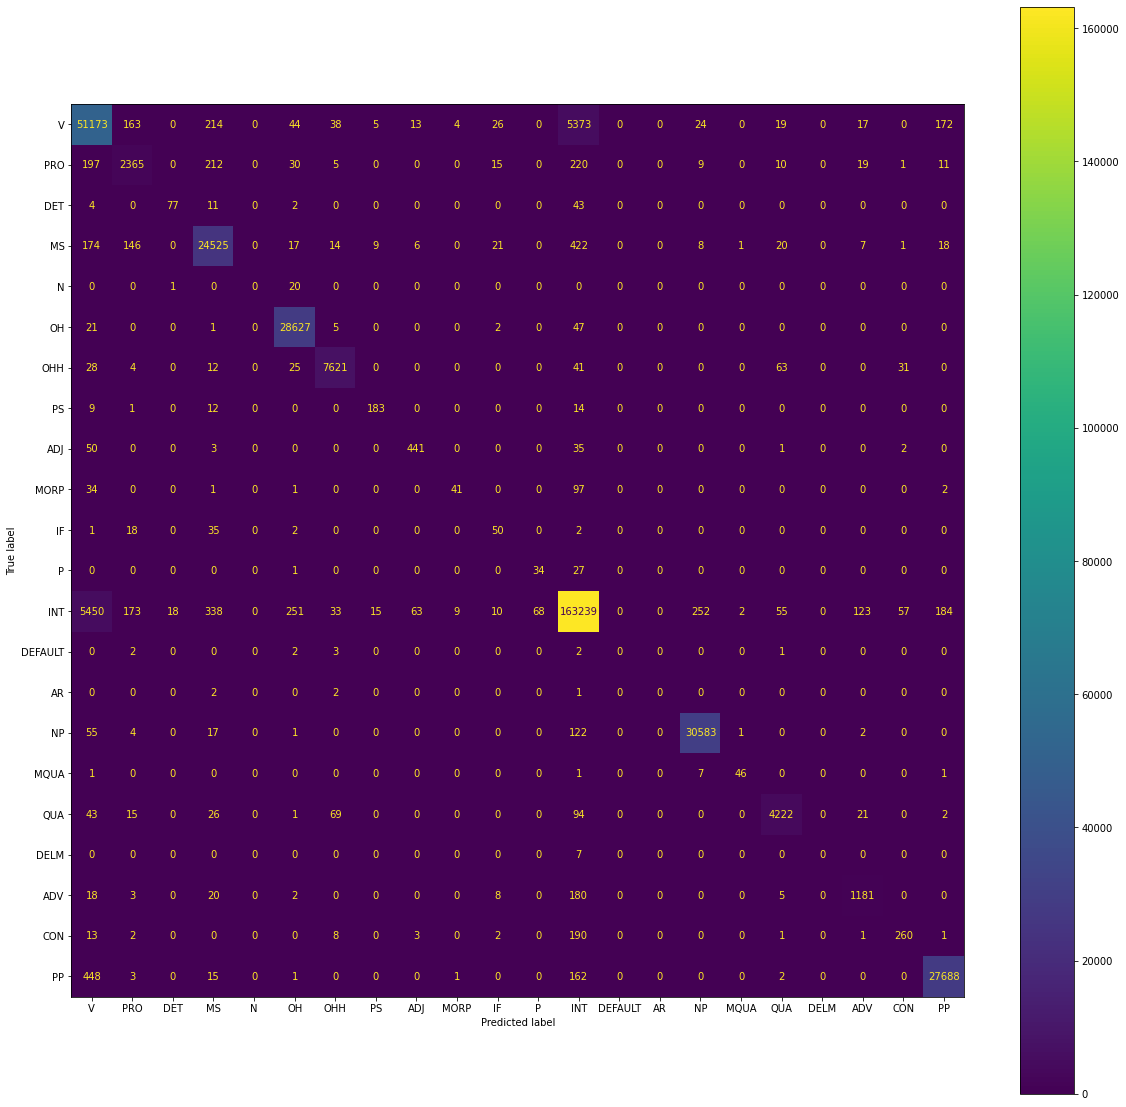

In [ ]:
cm = confusion_matrix(y_true = true, y_pred= pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(id2tag.values()))
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax = ax)
plt.show()

In [ ]:
accuracy_score(true, pred)

0.9524042674530204

In [ ]:
print(classification_report(true, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.89      0.89      0.89     57285
         ADV       0.82      0.76      0.79      3094
          AR       0.80      0.56      0.66       137
         CON       0.96      0.97      0.96     25389
     DEFAULT       0.00      0.00      0.00        21
        DELM       0.99      1.00      0.99     28703
         DET       0.98      0.97      0.98      7825
          IF       0.86      0.84      0.85       219
         INT       0.84      0.83      0.83       532
        MORP       0.75      0.23      0.35       176
        MQUA       0.37      0.46      0.41       108
          MS       0.33      0.55      0.41        62
           N       0.96      0.96      0.96    170340
          OH       0.00      0.00      0.00        10
         OHH       0.00      0.00      0.00         5
           P       0.99      0.99      0.99     30785
          PP       0.92      0.82      0.87        56
         PRO       0.96    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
